# MNIST Diffusion

Learn diffusion per the paper Jascha Sohl-Dickstein, Eric Weiss, Niru Maheswaranathan, and Surya Ganguli. Deep unsupervised
learning using nonequilibrium thermodynamics. In International Conference on Machine Learning, pages
2256–2265, 2015.

In [43]:
%matplotlib

import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

Using matplotlib backend: module://matplotlib_inline.backend_inline


# 1. Load MNIST dataset

In [50]:
transform = transforms.Compose([  # original MNIST are 28 x 28 images, greyscale - ints 0 to 255
    transforms.ToTensor(), # rescales to [0.0, 1.0]
    transforms.Lambda(lambda x: x * 2 - 1)  # Rescale to [-1.0, 1.0]
])


batch_size = 128


class InMemoryMNIST(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.data = []
        for i in range(len(dataset)):
            x, y = dataset[i]
            self.data.append((x.clone(), y))  # clone to detach from lazy loading

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

        
train_dataset = InMemoryMNIST(datasets.MNIST(root='./data', train=True, download=True, transform=transform))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = InMemoryMNIST(datasets.MNIST(root='./data', train=False, download=True, transform=transform))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)


# 2. Define the network used for reverse diffusion: MLP as in Appendix D.1.2

In [51]:
T = 1000

class DiffusionModel(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=100, T=T):
        super().__init__()
        self.T = T
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for time embedding
            nn.Softplus(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Softplus(),
            nn.Linear(hidden_dim, input_dim)  # Output mean for the reverse process
        )

    def forward(self, x_t, t):
        t_embed = t.view(-1, 1).float() / self.T  # Normalize time step
        x_input = torch.cat([x_t, t_embed], dim=1)
        return self.net(x_input)

# 3 Forward Diffusion Kernel (Gaussian Noise with Schedule Beta_t)

In [52]:
def q_sample(x_0, t, betas):
    noise = torch.randn_like(x_0)
    alpha_cumprod = torch.cumprod(1 - betas, dim=0)
    sqrt_alpha_cumprod = torch.sqrt(alpha_cumprod[t]).view(-1, 1)
    sqrt_one_minus_alpha = torch.sqrt(1 - alpha_cumprod[t]).view(-1, 1)
    return sqrt_alpha_cumprod * x_0 + sqrt_one_minus_alpha * noise

# 4 Training Loop

In [56]:
device = 'cpu'
model = DiffusionModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
betas = torch.linspace(1e-4, 0.02, T).to(device)


In [57]:
def train_one_epoch():
    model.train()
    total_loss = 0
    for x, _ in train_loader:
        x = x.view(x.size(0), -1).to(device)
        t = torch.randint(1, T, (x.size(0),), device=x.device)
        x_t = q_sample(x, t, betas)
        x_pred = model(x_t, t)
        loss = F.mse_loss(x_pred, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [59]:
t0 = time.time()
for epoch in range(50):
    loss = train_one_epoch()
    print(f"Epoch {epoch}: Loss = {loss:.4f}")
tm = time.time() - t0
print("Time: ", tm / 60.0)

Epoch 0: Loss = 0.1766
Epoch 1: Loss = 0.1763
Epoch 2: Loss = 0.1758
Epoch 3: Loss = 0.1749
Epoch 4: Loss = 0.1747
Epoch 5: Loss = 0.1746
Epoch 6: Loss = 0.1742
Epoch 7: Loss = 0.1740
Epoch 8: Loss = 0.1738
Epoch 9: Loss = 0.1730
Epoch 10: Loss = 0.1736
Epoch 11: Loss = 0.1734
Epoch 12: Loss = 0.1725
Epoch 13: Loss = 0.1734
Epoch 14: Loss = 0.1725
Epoch 15: Loss = 0.1727
Epoch 16: Loss = 0.1723
Epoch 17: Loss = 0.1719
Epoch 18: Loss = 0.1719
Epoch 19: Loss = 0.1716
Epoch 20: Loss = 0.1718
Epoch 21: Loss = 0.1714
Epoch 22: Loss = 0.1717
Epoch 23: Loss = 0.1717
Epoch 24: Loss = 0.1708
Epoch 25: Loss = 0.1711
Epoch 26: Loss = 0.1711
Epoch 27: Loss = 0.1714
Epoch 28: Loss = 0.1712
Epoch 29: Loss = 0.1713
Epoch 30: Loss = 0.1709
Epoch 31: Loss = 0.1707
Epoch 32: Loss = 0.1705
Epoch 33: Loss = 0.1706
Epoch 34: Loss = 0.1708
Epoch 35: Loss = 0.1712
Epoch 36: Loss = 0.1701
Epoch 37: Loss = 0.1708
Epoch 38: Loss = 0.1700
Epoch 39: Loss = 0.1705
Epoch 40: Loss = 0.1697
Epoch 41: Loss = 0.1704
Ep

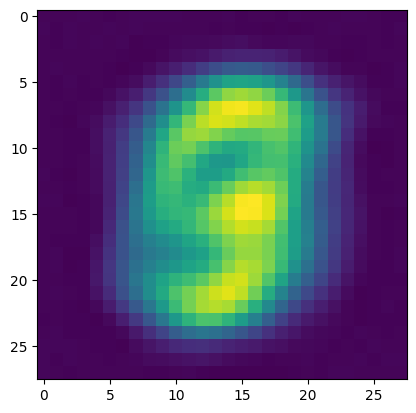

In [65]:
def make_image_one_shot(model):
    model.eval()
    with torch.no_grad():
        x = torch.randn(1, 28 * 28).to(device)
        t=torch.tensor(1000.0).to(device)
        v = model(x, t)
        v.reshape(1, 28, 28)
        return np.reshape(v.to('cpu').numpy(), (28, 28))

plt.imshow(make_image_one_shot(model))
    

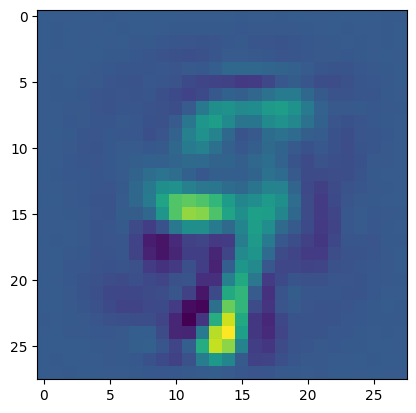

In [70]:
def make_image_multi_step(model):
    model.eval()
    with torch.no_grad():
        x_T = torch.randn(1, 784).to(device)  # noise
        x_t = x_T
    
        for t in reversed(range(1, T)):
            # Predict x0 from noisy xt and timestep
            x_pred = model(x_t, torch.tensor(t))
        
            # Compute mean of the reverse process (simplified)
            beta_t = betas[t]
            alpha_t = 1 - beta_t
            alpha_bar_t = torch.prod(1 - betas[:t+1])
        
            coef1 = 1 / torch.sqrt(alpha_t)
            coef2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        
            # Reverse update (this is a simplification)
            x_t = coef1 * (x_t - coef2 * (x_t - x_pred))  # or just x_pred in simplified models
    
    return np.reshape(x_t.to('cpu').numpy(), (28, 28))

plt.imshow(make_image_multi_step(model))
